### This notebook is to be ran after running classify_pyr_int.m in matlab.

In [114]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
import math
import seaborn as sns
import sys
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *
import re
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
import pickle
import multiprocessing
from joblib import Parallel, delayed

In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

%config InlineBackend.figure_format = 'retina'


import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

In [3]:
waves_zscore = np.load(r'F:\Projects\PAE_PlaceCell\analysis\cell_recruitment\processed\waves_zscore.npy')
acg_narrow = np.load(r'F:\Projects\PAE_PlaceCell\analysis\cell_recruitment\processed\acg_narrow.npy')
df_cell_class = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/cell_recruitment/processed/pyr_int_df.csv')
df_cell_class


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,session,tetrode,cell,acg_tau_decay,acg_tau_rise,acg_c,acg_d,...,short_isi,lv,cv,avg_fr,asymmetry,n_spikes,cell_type,area,rat,group
0,0,0,0,LEM3116_S20180715121821,TT1.mat,1,31.546309,0.573929,7.484840,1.810424,...,0.021529,1.149097,1.535871,2.529014,3.181064,7340,pyr,ca1,LEM3116,control
1,1,1,1,LEM3116_S20180715121821,TT1.mat,2,2.066006,2.058184,99.344603,1.086215,...,0.010545,1.041924,1.479007,0.392445,1.947498,1139,pyr,ca1,LEM3116,control
2,2,2,2,LEM3116_S20180715121821,TT2.mat,1,26.506166,0.781068,15.805209,1.504109,...,0.041928,1.235779,1.773778,2.580697,3.908416,7490,pyr,ca1,LEM3116,control
3,3,3,3,LEM3116_S20180715121821,TT3.mat,1,4.712647,3.339123,44.065945,3.111166,...,0.000555,1.032228,0.999013,0.621228,3.730098,1803,pyr,ca1,LEM3116,control
4,4,4,4,LEM3116_S20180715121821,TT3.mat,2,69.711440,1.119072,2.272114,4.029701,...,0.011062,0.983793,1.406165,2.959360,3.743105,8589,pyr,ca1,LEM3116,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8777,8777,8777,8777,RH16_S20161207130000,TT7.mat,5,13.648150,19.260993,4.054789,2.763695,...,0.000000,1.059228,5.973929,0.789008,4.629547,1252,pyr,ca1,RH16,pae
8778,8778,8778,8778,RH16_S20161207130000,TT7.mat,6,465.286016,6.540656,9.476762,1.811303,...,0.004489,0.735687,23.134516,13.056442,2.818769,20718,int,ca1,RH16,pae
8779,8779,8779,8779,RH16_S20161207130000,TT8.mat,1,40.117754,49.985020,7.880123,1.435894,...,0.000000,0.955257,6.281825,0.626417,21.188431,994,int,ca1,RH16,pae
8780,8780,8780,8780,RH16_S20161207130000,TT8.mat,2,5.123286,5.122541,5.461216,5.218173,...,0.021382,0.999326,31.814075,1.533272,2.350860,2433,pyr,ca1,RH16,pae


### add area to data frame

In [4]:
channel_list = pd.read_csv(r'F:\Projects\PAE_PlaceCell\analysis\channel_list.csv')

area = []
for cell in df_cell_class.itertuples():
    # extract tetrode number
    m=re.search('TT(.+?).mat', cell.tetrode)
    tetrode = int(m.group(1))
    idx = (channel_list.session == cell.session) & (channel_list.channel == tetrode)
    if any(idx):
        area.append(channel_list[idx].area.iloc[0])
    else:
        area.append(np.nan)

df_cell_class['area'] = area
df_cell_class

,Unnamed: 0,session,tetrode,cell,acg_tau_decay,acg_tau_rise,acg_c,acg_d,acg_asymptote,acg_refrac,...,trough,spkW,short_isi,lv,cv,avg_fr,asymmetry,n_spikes,cell_type,area
0,0,LEM3116_S20180715121821,TT1.mat,1,31.546309,0.573929,7.484840,1.810424,4.267133,3.757487,...,-2.393640,0.777777,0.021529,1.149097,1.535871,2.529014,3.181064,7340,pyr,ca1
1,1,LEM3116_S20180715121821,TT1.mat,2,2.066006,2.058184,99.344603,1.086215,2.731016,7.293023,...,-2.027969,0.930761,0.010545,1.041924,1.479007,0.392445,1.947498,1139,pyr,ca1
2,2,LEM3116_S20180715121821,TT2.mat,1,26.506166,0.781068,15.805209,1.504109,4.955974,4.657924,...,-2.491995,0.777777,0.041928,1.235779,1.773778,2.580697,3.908416,7490,pyr,ca1
3,3,LEM3116_S20180715121821,TT3.mat,1,4.712647,3.339123,44.065945,3.111166,0.573573,1.285490,...,-2.784299,0.571703,0.000555,1.032228,0.999013,0.621228,3.730098,1803,pyr,ca1
4,4,LEM3116_S20180715121821,TT3.mat,2,69.711440,1.119072,2.272114,4.029701,6.440918,4.588725,...,-2.683800,0.684153,0.011062,0.983793,1.406165,2.959360,3.743105,8589,pyr,ca1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8777,8777,RH16_S20161207130000,TT7.mat,5,13.648150,19.260993,4.054789,2.763695,3.311529,0.086722,...,-2.886261,0.529358,0.000000,1.059228,5.973929,0.789008,4.629547,1252,pyr,ca1
8778,8778,RH16_S20161207130000,TT7.mat,6,465.286016,6.540656,9.476762,1.811303,12.260592,0.000135,...,-3.028445,0.271706,0.004489,0.735687,23.134516,13.056442,2.818769,20718,int,ca1
8779,8779,RH16_S20161207130000,TT8.mat,1,40.117754,49.985020,7.880123,1.435894,3.685590,0.000087,...,-2.461559,0.286010,0.000000,0.955257,6.281825,0.626417,21.188431,994,int,ca1
8780,8780,RH16_S20161207130000,TT8.mat,2,5.123286,5.122541,5.461216,5.218173,9.395189,0.011953,...,-2.361157,0.701930,0.021382,0.999326,31.814075,1.533272,2.350860,2433,pyr,ca1


### classify cells

In [5]:
df_cell_class.cell_type = 'unidentified'
df_cell_class.loc[(df_cell_class.spkW < .5), "cell_type"] = 'int'
df_cell_class.loc[(df_cell_class.spkW > .5) & (df_cell_class.spkW < 3), "cell_type"] = 'pyr'
# There are some odd waveforms due to neuralynx spike detection
# here, I split the unidentified by ab ratio which seems produce two unique classes of autocorrs (burst & regular spiking)
df_cell_class.loc[(df_cell_class.cell_type=='unidentified') & (df_cell_class.ab_ratio>0), "cell_type"] = 'int'
df_cell_class.loc[(df_cell_class.cell_type=='unidentified') & (df_cell_class.ab_ratio<0), "cell_type"] = 'pyr'

### export csv with cell class with new variables (area & cell_type)

In [6]:
df_cell_class.to_csv(r'F:\Projects\PAE_PlaceCell\analysis\cell_recruitment\processed\pyr_int_df.csv')

### Only keep ca1 and ca3 for plotting and comparisons

In [4]:
idx = (df_cell_class['area'] == 'ca1') | (df_cell_class['area'] == 'ca3')

df_cell_class = df_cell_class[idx]
acg_narrow = acg_narrow[idx]
waves_zscore = waves_zscore[idx]

### flip waveforms that need to be flipped for plots

I used a polarity measure to initially orient them, but the very symmetric waveforms cause some issues.

Here I look aroud where I expect the trough to be. If that spot has a peak, I'll flip it.

In [5]:
max_idx = [np.argmax(np.abs(w)) for w in waves_zscore]

peaks = []
for w in waves_zscore:
    peak,_ = find_peaks(w)
    peaks.append(peak)
to_flip = [np.any((w >= 28-1) & (w<=28+1)) for w in peaks]
waves_zscore_flipped = waves_zscore.copy()
waves_zscore_flipped[to_flip] = waves_zscore_flipped[to_flip]*-1

### make histrogram of spike duration

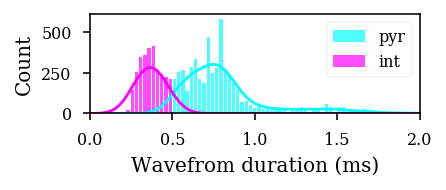

In [8]:
# cmap = plt.get_cmap("tab10")
cmap = plt.get_cmap("cool_r",2)

ax = plt.figure(figsize=set_size('thesis', fraction=0.5, subplots=(1,2)), edgecolor='k')

hist,bin_edges=np.histogram(df_cell_class.spkW[df_cell_class.cell_type=='pyr'],bins=np.arange(0,2,.025))
bin_centers = np.linspace(0, 2, len(hist))
smooth_hist = gaussian_filter1d(hist, 3)
plt.bar(bin_centers,hist,width=.02,alpha=.7,color=cmap(1),label='pyr')
plt.plot(bin_centers,smooth_hist,color=cmap(1))

hist,bin_edges = np.histogram(df_cell_class.spkW[df_cell_class.cell_type=='int'],bins=np.arange(0,2,.025))
bin_centers = np.linspace(0, 2, len(hist))
smooth_hist = gaussian_filter1d(hist, 3)
plt.bar(bin_centers,hist,width=.02,alpha=.7,color=cmap(0),label='int')
plt.plot(bin_centers,smooth_hist,color=cmap(0))
plt.xlim(0,2)
plt.xlabel('Wavefrom duration (ms)')
plt.ylabel('Count')

plt.legend()

save_path = "D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_recuitment/"
plt.savefig(save_path+'waveform_duration.svg',dpi=300,bbox_inches='tight')

### make waveforms and acg plots

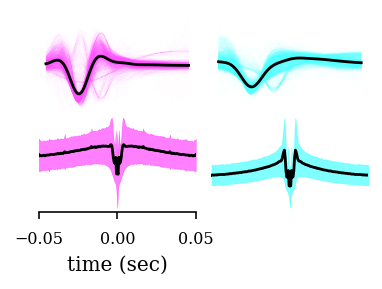

In [21]:
labels = df_cell_class.cell_type
cmap = plt.get_cmap("cool_r",2)

fig, axs = plt.subplots(2,2, figsize=set_size('thesis', fraction=.5, subplots=(2,2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.1)
axs = axs.ravel()

axs[0].plot(waves_zscore_flipped[labels=='int'].T,alpha=.01,color=cmap(0),linewidth=.5)
axs[0].axis('off')
axs[0].set_rasterized(True)
axs[0].plot(np.mean(waves_zscore_flipped[labels=='int'],axis=0),color='k')


axs[1].plot(waves_zscore_flipped[labels=='pyr'].T,alpha=.01,color=cmap(1),linewidth=.5)
axs[1].axis('off')
axs[1].set_rasterized(True)
axs[1].plot(np.mean(waves_zscore_flipped[labels=='pyr'],axis=0),color='k')


temp_acg = acg_narrow[labels=='int'] 
temp_acg = preprocessing.normalize(temp_acg)
x = np.arange(-.05,.05+0.0005/2,0.0005)
y = np.mean(temp_acg,axis=0)
std = np.std(temp_acg,axis=0)
axs[2].fill_between(x, y-std, y+std,color=cmap(0),alpha=.5)
axs[2].plot(x,y,'k')
axs[2].set_xlim(-.05,0.05)
axs[2].axes.get_yaxis().set_ticks([])
axs[2].set_xlabel('time (sec)')

temp_acg = acg_narrow[labels=='pyr'] 
temp_acg = preprocessing.normalize(temp_acg)
x = np.arange(-.05,.05+0.0005/2,0.0005)
y = np.mean(temp_acg,axis=0)
std = np.std(temp_acg,axis=0)
axs[3].fill_between(x, y-std, y+std,color=cmap(1),alpha=.5)
axs[3].plot(x,y,'k')
axs[3].set_xlim(-.05,0.05)
axs[3].axes.get_yaxis().set_ticks([])
axs[3].axis('off')

for i in range(4):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].spines["top"].set_visible(False)


save_path = "D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_recuitment/"
plt.savefig(save_path+'waveform_acg.svg',dpi=300,bbox_inches='tight')

### make proportion plots

In [10]:
def add_group_affiliation(df):
    control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
    pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

    df['group'] = np.ones_like(df.session)

    regstr = '|'.join(control)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx, "group"] = 'control'

    regstr = '|'.join(pae)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx, "group"] = 'pae'
    return df
    
df_cell_class = add_group_affiliation(df_cell_class)

<ipython-input-10-17608247509a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = np.ones_like(df.session)
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


### get proportion of cell class per area per group

In [11]:
temp_df = df_cell_class[df_cell_class.area == 'ca1']
class_counts_ca1 = pd.crosstab(temp_df.cell_type, temp_df.group,
                rownames=['cell classification'],
                colnames=['group']).apply(lambda r: r/r.sum(), axis=0).stack().reset_index().rename(columns={0:'value'})
class_counts_ca1['area'] = 'ca1'

temp_df = df_cell_class[df_cell_class.area == 'ca3']
class_counts_ca3 = pd.crosstab(temp_df.cell_type, temp_df.group,
                rownames=['cell classification'],
                colnames=['group']).apply(lambda r: r/r.sum(), axis=0).stack().reset_index().rename(columns={0:'value'})
class_counts_ca3['area'] = 'ca3'

class_counts = pd.concat([class_counts_ca1, class_counts_ca3])

class_counts

,cell classification,group,value,area
0,int,control,0.305699,ca1
1,int,pae,0.400000,ca1
2,pyr,control,0.694301,ca1
3,pyr,pae,0.600000,ca1
0,int,control,0.240409,ca3
1,int,pae,0.395107,ca3
2,pyr,control,0.759591,ca3
3,pyr,pae,0.604893,ca3


In [14]:
cmap = plt.get_cmap("cool_r",2)
cmap(0)

(1.0, 0.0, 1.0, 1.0)

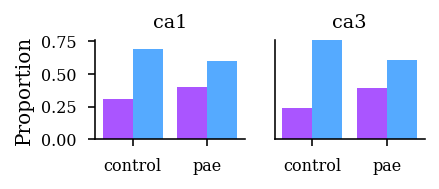

In [22]:
f, ax = plt.subplots(1,2,figsize=set_size('thesis', fraction=.5, subplots=(1, 2)))
fig.subplots_adjust(hspace = 0, wspace=0)
ax = ax.ravel()
max_value = max(class_counts.value)


sns.set_palette(sns.color_palette("cool_r", 2))
sns.barplot(x="group", y="value",hue = "cell classification", data=class_counts[class_counts.area=='ca1'],order=['control','pae'],ax=ax[0],saturation=1,alpha=1)
ax[0].legend([],[], frameon=False)
ax[0].set(ylabel="Proportion")
# sns.despine(trim=False, left=True)
ax[0].set_ylim(0,max_value)
ax[0].set_title('ca1')
ax[0].set_xlabel('')
ax[0].set_yticks(np.arange(0,max_value,.25))


# sns.set_palette(palette=["#FF7F0E",'#1F77B4','#2CA02C','#D3D3D3'])
g = sns.barplot(x="group", y="value",hue = "cell classification", data=class_counts[class_counts.area=='ca3'],order=['control','pae'],ax=ax[1],saturation=1,alpha=1)
ax[1].legend([],[], frameon=False)
ax[1].set(ylabel="Proportion")
ax[1].axes.get_yaxis().set_ticks([])
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_ylim(0,max_value)
ax[1].set_title('ca3')
# ax[1].spines["left"].set_visible(False)
sns.despine(trim=False, right=True)

save_path = "D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_recuitment/"
plt.savefig(save_path+'cell_class_prop.svg',dpi=300,bbox_inches='tight')

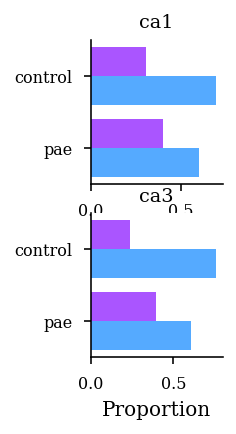

In [24]:
f, ax = plt.subplots(2,1,figsize=set_size('thesis', fraction=.2, subplots=(4, 1)))
fig.subplots_adjust(hspace = 0, wspace=0)
ax = ax.ravel()

max_value = max(class_counts.value)

# sns.set_palette(palette=['#1F77B4',"#FF7F0E",'#2CA02C','#D3D3D3'])
sns.set_palette(sns.color_palette("cool_r", 2))
sns.barplot(y="group", x="value",hue = "cell classification", data=class_counts[class_counts.area=='ca1'],order=['control','pae'],ax=ax[0],saturation=1,alpha=1)
ax[0].legend([],[], frameon=False)
ax[0].set_title('ca1')
ax[0].set_ylabel('')
ax[0].set_xlabel('')

# ax[0].axes.get_xaxis().set_ticks([])


g = sns.barplot(y="group", x="value",hue = "cell classification", data=class_counts[class_counts.area=='ca3'],order=['control','pae'],ax=ax[1],saturation=1,alpha=1)
ax[1].legend([],[], frameon=False)
ax[1].set(xlabel="Proportion")
ax[1].set_ylabel('')
ax[1].set_title('ca3')


sns.despine(trim=False, right=True)

save_path = "D:/ryanh/GoogleDrive/school_work/UNM/Lab/Projects/Dissertation/dissertation/inkscape_figs/ripple_recuitment/"
plt.savefig(save_path+'cell_class_prop_v2.svg',dpi=300,bbox_inches='tight')

## get prop of pyr/int units per session

...however some rats have tetrodes in multipe areas in a recording so the proportion will need to be calculated on the basis of each area instead of each session

because I have no unidentified units, interneurons proportions will just be 1-prop_pyr

<ipython-input-11-4fae4256714d>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cell_class['session_area'] = df_cell_class.session+df_cell_class.area


,session,rat,group,area,prop_pyr,n_cells
0,LEM3116_S20180715121821,LEM3116,control,ca1,0.720000,25
1,LEM3116_S20180715160836,LEM3116,control,ca1,0.833333,6
2,LEM3116_S20180716115155,LEM3116,control,ca1,0.625000,8
3,LEM3116_S20180716174306,LEM3116,control,ca1,0.805556,36
4,LEM3116_S20180717110938,LEM3116,control,ca1,0.777778,108


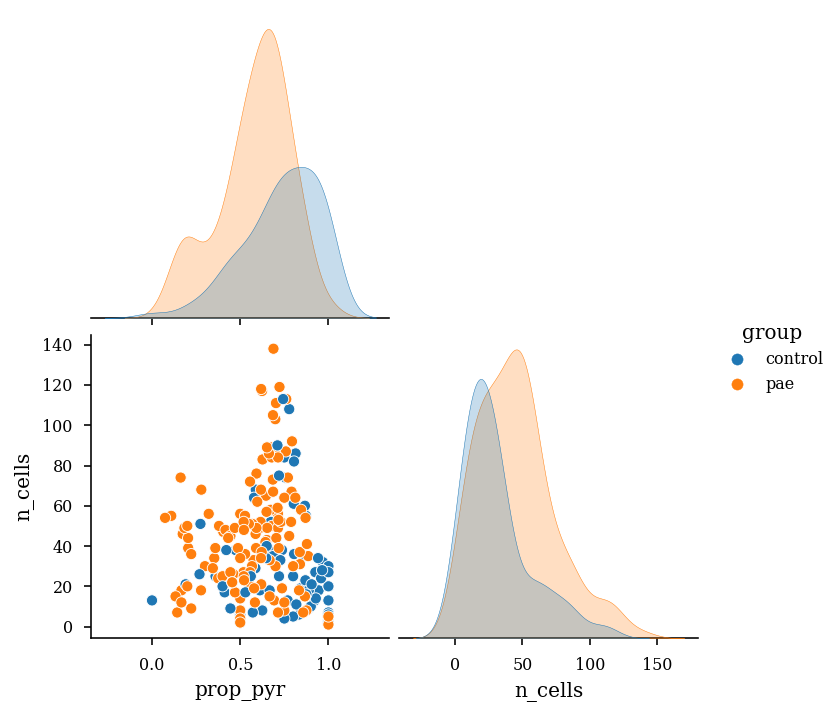

In [11]:
def add_group_affiliation(df):
    control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
    pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

    df['group'] = np.ones_like(df.session)

    regstr = '|'.join(control)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx, "group"] = 'control'

    regstr = '|'.join(pae)
    idx = df['session'].str.upper().str.contains(regstr)    
    df.loc[idx, "group"] = 'pae'
    return df

# get combo of session and area because one rat as tetrodes in multiple areas
df_cell_class['session_area'] = df_cell_class.session+df_cell_class.area

n_cells = []
prop_pyr = []
# loop through each unique session/area id
for session in pd.unique(df_cell_class.session_area):
    n_pyr = sum(df_cell_class.cell_type[df_cell_class.session_area == session] == 'pyr')
    n_cells.append(sum(df_cell_class.session_area == session))
    prop_pyr.append(n_pyr / n_cells[-1])

df_prop = pd.DataFrame()

df_prop['session'] = pd.unique(df_cell_class.session_area)

rat = [s.split('_')[0] for s in df_prop.session]
df_prop['rat']=rat
df_prop = add_group_affiliation(df_prop)
df_prop['area'] = df_prop.session.map(lambda x: str(x)[-3:])
df_prop['session'] = df_prop.session.map(lambda x: str(x)[:-3])

df_prop['prop_pyr'] = prop_pyr
df_prop['n_cells'] = n_cells

display(df_prop.head())
sns.pairplot(df_prop,hue="group",corner=True)

df_prop.to_csv(r'F:\Projects\PAE_PlaceCell\analysis\cell_recruitment\processed\df_prop.csv')


## Make scatter comparison where each point's alpha value is dependent on the number of units

### add int prop for plotting

In [13]:
df_prop['prop_int'] = 1-df_prop.prop_pyr

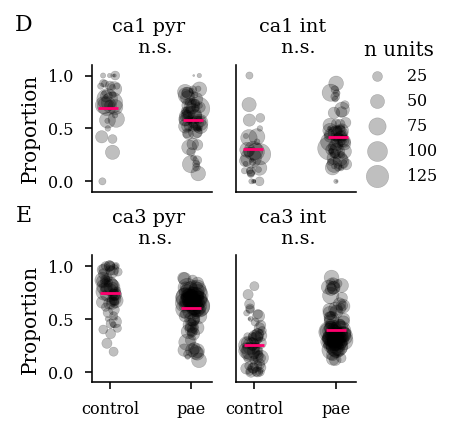

In [291]:
def weighted_average_m1(distribution, weights):
    return sum([distribution[i]*weights[i] for i in range(len(distribution))])/sum(weights)


def plot_prop_custom(df_prop,y_name,ax):
#     x = (df_prop.group == 'pae') * 1 + (np.random.rand(len(df_prop))*.3)
    x = (df_prop.group == 'pae') * 1 + (np.random.randint(-100,100,len(df_prop))*.001)

    y = df_prop[y_name]
    h = ax.scatter(
        x,y,
        color='k',
        alpha=.25,
        s=df_prop.n_cells
    )
    
    mean = weighted_average_m1(
        np.array(df_prop[(df_prop.group=='control')][y_name]),
        np.array(df_prop[(df_prop.group=='control')].n_cells)
    )
    ax.scatter(0,mean,marker="_",color='#ff006e',s=100)
    
    mean = weighted_average_m1(
        np.array(df_prop[(df_prop.group=='pae')][y_name]),
        np.array(df_prop[(df_prop.group=='pae')].n_cells)
    )
    ax.scatter(1,mean,marker="_",color='#ff006e',s=100)
                               
    ax.set_xticks([0,1])
    ax.set_xticklabels(['control','pae'])
    return h
        
fig, ax = plt.subplots(2,2,figsize=set_size('thesis', fraction=.4, subplots=(2, 1)))
fig.subplots_adjust(hspace = .5, wspace=.2)
ax = ax.ravel()

h0 = plot_prop_custom(df_prop[df_prop.area=='ca1'],'prop_pyr',ax[0])
plot_prop_custom(df_prop[df_prop.area=='ca1'],'prop_int',ax[1])
plot_prop_custom(df_prop[df_prop.area=='ca3'],'prop_pyr',ax[2])
plot_prop_custom(df_prop[df_prop.area=='ca3'],'prop_int',ax[3])

handles, labels = h0.legend_elements(num=6,prop="sizes", alpha=0.25)
legend2 = ax[1].legend(handles, labels, loc='upper right', bbox_to_anchor=(1.3, 0.8, 0.5, 0.5), title="n units",frameon=False)

ax[0].set_title('ca1 pyr \n n.s.')
ax[1].set_title('ca1 int \n n.s.')
ax[2].set_title('ca3 pyr \n n.s.')
ax[3].set_title('ca3 int \n n.s.')

ax[0].set(xlabel="")
sns.despine(trim=False, right=True)

ax[0].set_ylim(-.1,1.1)
ax[1].set_ylim(-.1,1.1)
ax[2].set_ylim(-.1,1.1)
ax[3].set_ylim(-.1,1.1)

ax[0].set_ylabel('Proportion')
ax[1].set_ylabel('')
ax[2].set_ylabel('Proportion')
ax[3].set_ylabel('')

ax[1].axes.get_yaxis().set_ticks([])
ax[3].axes.get_yaxis().set_ticks([])

ax[0].axes.get_xaxis().set_ticks([])
ax[1].axes.get_xaxis().set_ticks([])

ax[0].text(-0.5, 1.4, 'D', transform=ax[0].transAxes,fontsize=11, fontweight='normal', va='top', ha='right')
ax[2].text(-0.5, 1.4, 'E', transform=ax[2].transAxes,fontsize=11, fontweight='normal', va='top', ha='right')

plt.savefig(r'D:\ryanh\GoogleDrive\school_work\UNM\Lab\Projects\Dissertation\dissertation\inkscape_figs\ripple_recuitment\pyr_int_prop_per_session_v3.svg',dpi=300,bbox_inches='tight')


# redo burst index

based on burst index from royer 2012
the normalization is different from the burst index already calculated

In [153]:
# crossCorr functions from Guillaume Viejo of Peyrache Lab
# https://github.com/PeyracheLab/StarterPack/blob/master/python/main6_autocorr.py

def crossCorr(t1, t2, binsize, nbins):
	''' 
		Fast crossCorr 
	'''
	nt1 = len(t1)
	nt2 = len(t2)
	if np.floor(nbins/2)*2 == nbins:
		nbins = nbins+1

	m = -binsize*((nbins+1)/2)
	B = np.zeros(nbins)
	for j in range(nbins):
		B[j] = m+j*binsize

	w = ((nbins/2) * binsize)
	C = np.zeros(nbins)
	i2 = 1

	for i1 in range(nt1):
		lbound = t1[i1] - w
		while i2 < nt2 and t2[i2] < lbound:
			i2 = i2+1
		while i2 > 1 and t2[i2-1] > lbound:
			i2 = i2-1

		rbound = lbound
		l = i2
		for j in range(nbins):
			k = 0
			rbound = rbound+binsize
			while l < nt2 and t2[l] < rbound:
				l = l+1
				k = k+1

			C[j] += k

	# for j in range(nbins):
	# C[j] = C[j] / (nt1 * binsize)
	C = C/(nt1 * binsize)

	return C

def compute_AutoCorrs(spks, binsize = 0.001, nbins = 100):
    # First let's prepare a pandas dataframe to receive the data
    times = np.arange(0, binsize*(nbins+1), binsize) - (nbins*binsize)/2	
    autocorrs = pd.DataFrame(index = times, columns = np.arange(len(spks)))

    # Now we can iterate over the dictionnary of spikes
    for i,s in enumerate(spks):		
        # Calling the crossCorr function
        autocorrs[i] = crossCorr(s, s, binsize, nbins)

    # And don't forget to replace the 0 ms for 0
    autocorrs.loc[0] = 0.0
    return autocorrs

def BurstIndex_Royer_2012(autocorrs):
    # calc burst index from royer 2012
    # burst_idx will range from -1 to 1
    # -1 being non-bursty and 1 being bursty
    
    # peak range 2 - 9 ms
    peak = autocorrs.loc[0.002:0.009].max()
    # baseline idx 40 - 50 ms
    baseline = autocorrs.loc[0.04:0.05].mean()

    burst_idx = []
    for p, b in zip(peak, baseline):
        if p > b:
            burst_idx.append((p-b)/p)
        elif p < b:
            burst_idx.append((p-b)/b)
        else:
            burst_idx.append(np.nan)
    return burst_idx   

In [154]:
def run_analysis(spike_path,session):
    # pull in spike times for each unit
    spikes = np.load(os.path.join(spike_path,session)+'.npy', allow_pickle=True)
    # make autocorrelograms
    autocorrs = compute_AutoCorrs(spikes)
    # calc burst index based on the autocorrelograms
    return BurstIndex_Royer_2012(autocorrs)

def main_loop(spike_path,session,save_path):
    '''
    main_loop: file management 
    '''
    
    base = os.path.basename(session)
    os.path.splitext(base)
    save_file = os.path.join(save_path, os.path.splitext(base)[0] + '.pkl')
    
    # check if saved file exists
    if os.path.exists(save_file):
        return
        
    # calc some features
    results = run_analysis(spike_path,session)
    # save file
    with open(save_file, 'wb') as f:
        pickle.dump(results, f)
        
def burst_index_run(df_cell_class,spike_path,session,save_path,parallel=True):
    """
    function to loop through each session
    you can use a basic loop or run in parallel
    """

    # find sessions to run
    sessions = pd.unique(df_cell_class.session)

    if parallel:
        num_cores = multiprocessing.cpu_count()         
        processed_list = Parallel(n_jobs=num_cores)(delayed(main_loop)(spike_path,session,save_path
                                                                       ) for session in tqdm(sessions))
    else:    
        for session in tqdm(sessions):
            print(session)
            main_loop(spike_path,session,save_path)        

In [156]:
df_cell_class = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/cell_recruitment/processed/pyr_int_df.csv')

save_path = 'F:/Projects/PAE_PlaceCell/analysis/burst_index/'
spike_path = 'F:/Projects/PAE_PlaceCell/analysis/spikes'

burst_index_run(df_cell_class,spike_path,session,save_path,parallel=True)

100%|██████████████████████████████████████████████████████████████████████████████| 204/204 [1:01:56<00:00, 18.22s/it]


In [157]:
import glob

def load_in_everything(save_path):

    results=[]
    sessions = glob.glob(save_path + '*.pkl')
    for session in sessions:
        with open(session, 'rb') as f:
            results.append(pickle.load(f))

    return np.hstack(results)

results = load_in_everything(save_path)

### get CV2 

should have collected it above, but forgot

In [158]:
def cv2(time_intervals):
    # from https://elephant.readthedocs.io/en/latest/_modules/elephant/statistics.html#cv2
    
    # convert to array, cast to float
    time_intervals = np.asarray(time_intervals)

    # calculate Cv2 and return result
    cv_i = np.diff(time_intervals) / (time_intervals[:-1] + time_intervals[1:])
    return 2. * np.mean(np.abs(cv_i))

sessions = pd.unique(df_cell_class.session)

cv_2 = []
for session in tqdm(sessions):
    spikes = np.load(os.path.join(spike_path,session)+'.npy', allow_pickle=True)
    for s in spikes:
        cv_2.append(cv2(s))

100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:03<00:00, 67.89it/s]


In [159]:
df_cell_class['burst_index'] = results
df_cell_class['cv_2'] = cv_2

df_cell_class

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,session,tetrode,cell,acg_tau_decay,acg_tau_rise,acg_c,acg_d,...,cv,avg_fr,asymmetry,n_spikes,cell_type,area,rat,group,burst_index,cv_2
0,0,0,0,LEM3116_S20180715121821,TT1.mat,1,31.546309,0.573929,7.484840,1.810424,...,1.535871,2.529014,3.181064,7340,pyr,ca1,LEM3116,control,0.523711,0.001339
1,1,1,1,LEM3116_S20180715121821,TT1.mat,2,2.066006,2.058184,99.344603,1.086215,...,1.479007,0.392445,1.947498,1139,pyr,ca1,LEM3116,control,0.700000,0.005466
2,2,2,2,LEM3116_S20180715121821,TT2.mat,1,26.506166,0.781068,15.805209,1.504109,...,1.773778,2.580697,3.908416,7490,pyr,ca1,LEM3116,control,0.689394,0.001303
3,3,3,3,LEM3116_S20180715121821,TT3.mat,1,4.712647,3.339123,44.065945,3.111166,...,0.999013,0.621228,3.730098,1803,pyr,ca1,LEM3116,control,0.700000,0.004315
4,4,4,4,LEM3116_S20180715121821,TT3.mat,2,69.711440,1.119072,2.272114,4.029701,...,1.406165,2.959360,3.743105,8589,pyr,ca1,LEM3116,control,0.210843,0.001096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8777,8777,8777,8777,RH16_S20161207130000,TT7.mat,5,13.648150,19.260993,4.054789,2.763695,...,5.973929,0.789008,4.629547,1252,pyr,ca1,RH16,pae,-0.655172,0.005274
8778,8778,8778,8778,RH16_S20161207130000,TT7.mat,6,465.286016,6.540656,9.476762,1.811303,...,23.134516,13.056442,2.818769,20718,int,ca1,RH16,pae,-0.164722,0.000486
8779,8779,8779,8779,RH16_S20161207130000,TT8.mat,1,40.117754,49.985020,7.880123,1.435894,...,6.281825,0.626417,21.188431,994,int,ca1,RH16,pae,0.150000,0.004539
8780,8780,8780,8780,RH16_S20161207130000,TT8.mat,2,5.123286,5.122541,5.461216,5.218173,...,31.814075,1.533272,2.350860,2433,pyr,ca1,RH16,pae,0.264516,0.004058


In [160]:
df_cell_class.keys()

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'session', 'tetrode',
       'cell', 'acg_tau_decay', 'acg_tau_rise', 'acg_c', 'acg_d',
       'acg_asymptote', 'acg_refrac', 'acg_tau_burst', 'acg_h',
       'acg_fit_rsquare', 'thetaModulationIndex', 'burstIndex_Royer2012',
       'burstIndex_Doublets', 'polarity', 'peaktoTrough', 'troughtoPeak',
       'derivative_TroughtoPeak', 'peakA', 'peakB', 'ab_ratio', 'trough',
       'spkW', 'short_isi', 'lv', 'cv', 'avg_fr', 'asymmetry', 'n_spikes',
       'cell_type', 'area', 'rat', 'group', 'burst_index', 'cv_2'],
      dtype='object')

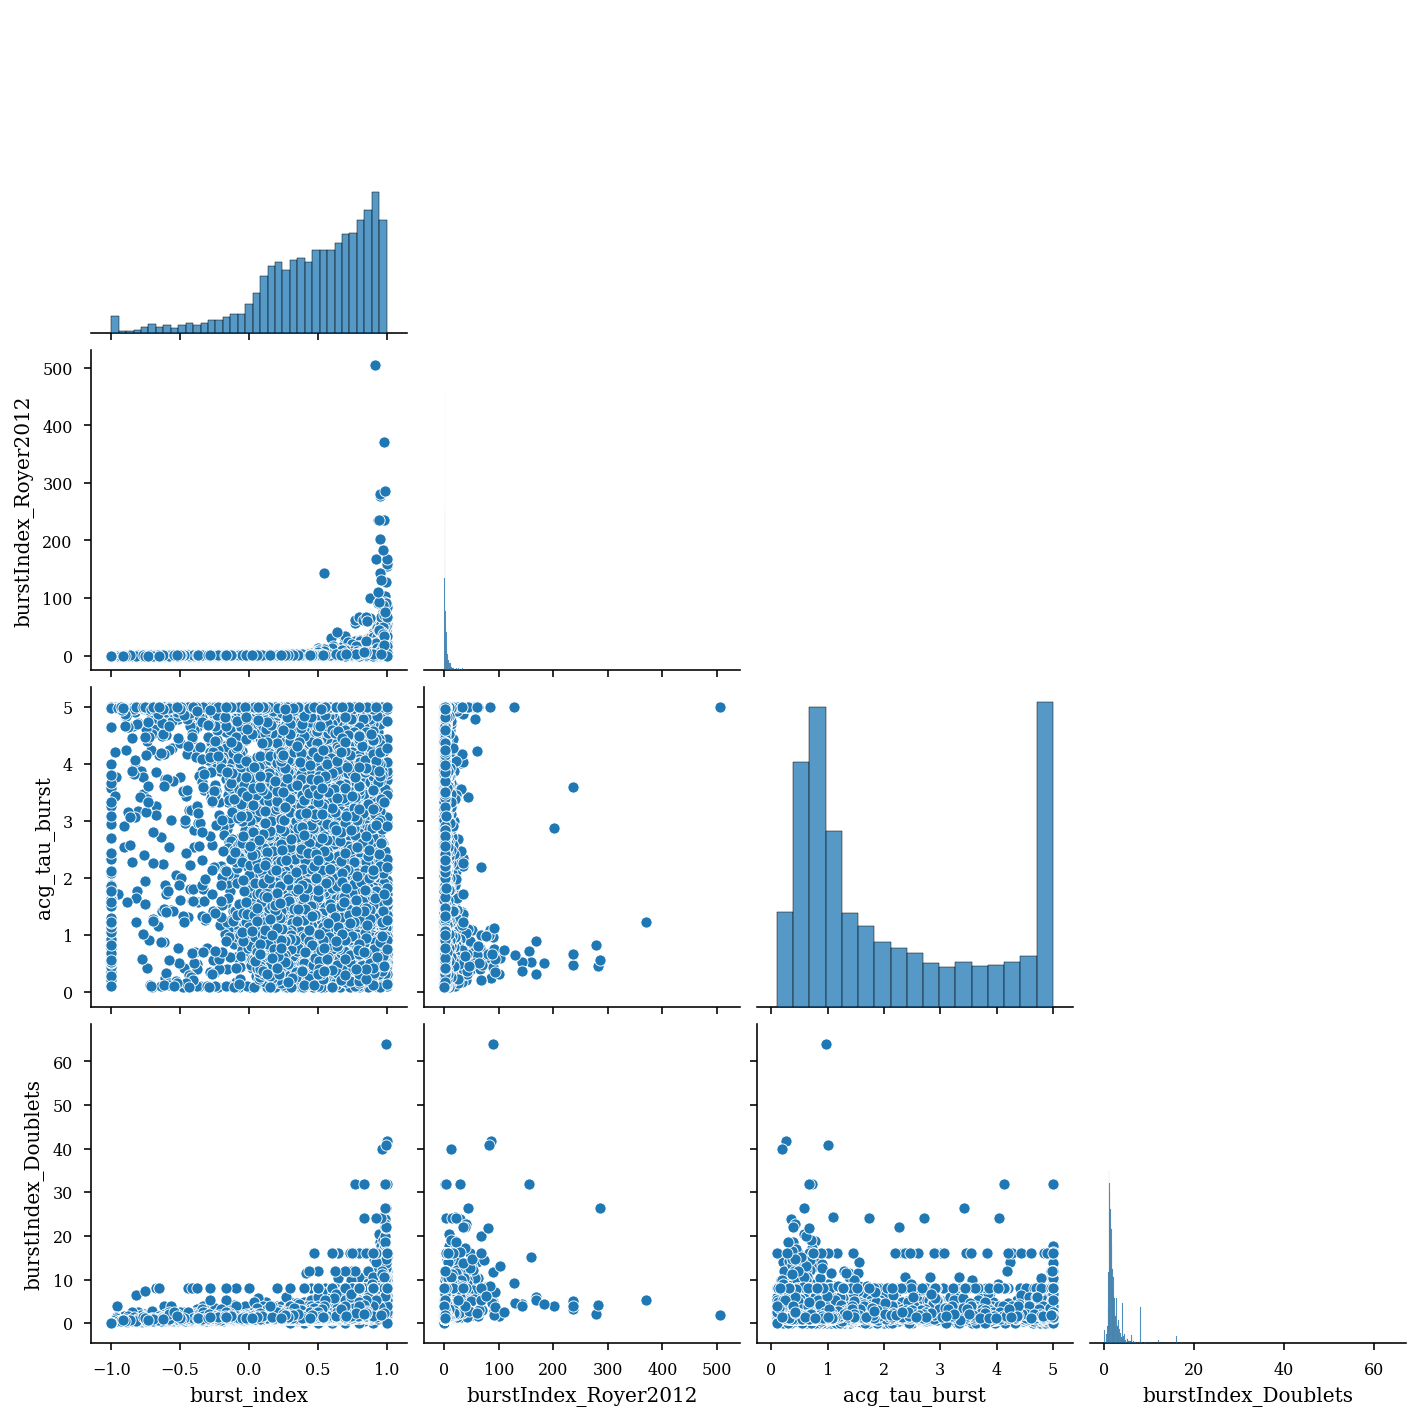

In [161]:
# plt.scatter(df_cell_class.burstIndex_Doublets,df_cell_class.burst_index)
df_cell_class.replace([np.inf, -np.inf], np.nan, inplace=True)

sns.pairplot(df_cell_class,corner=True,vars=['burst_index','burstIndex_Royer2012','acg_tau_burst','burstIndex_Doublets'])


In [162]:
df_cell_class.to_csv(r'F:\Projects\PAE_PlaceCell\analysis\burst_index\post_processed\df_cell_class_with_burst.csv')